In [1]:
import jax.numpy as jnp
from jax import jit 
from jax.flatten_util import ravel_pytree

import numpy as np
import scipy
import matplotlib.pyplot as plt
import interpax
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline

from adoptODE import train_adoptODE, simple_simulation, dataset_adoptODE
from HelperAndMechanics import *
import progressbar
import h5py

In [2]:
N,size,[] = read_config([],mode = 'chaos')

# Load from HDF5
with h5py.File('../data/SpringMassModel/MechanicalData/data_eta05.h5', 'r') as f:
    x_temp = f['x_temp'][:]
    x_cm_temp = f['x_cm_temp'][:]
    T = f['T'][:]
    dA = f['dA'][:]
    f.close()

In [3]:
N,size,ls = read_config(["l_0","c_a","k_ij","k_j","k_a","m","c_damp","n_0","delta_t_m","it_m","pad"])
l_0, c_a, k_g0, k_p0, k_a0, m0, nu0, eta0, delta_t_m, it_m, pad = ls
l_a0,l_p0,l_g0 = ((eta0-1/2)**2+1/2**2)**(1/2), ((eta0-1/2)**2+1/2**2)**(1/2), l_0

real_params = {'l_p':l_p0,'l_g':l_g0,'k_g':k_g0,'k_p':k_p0,'k_a':k_a0,'m':m0,'nu':nu0,'eta':eta0,'dt':0}

delta_t = delta_t_m * it_m
N_interp = int(it_m)*10

In [4]:
i,j = 50,50
maxima, _ = find_peaks(dA[:,i-1,j-1])
minima, _ = find_peaks(-dA[:,i-1,j-1])

#define the time interval for the standard peak and adoptODE
max_indx = 0

if minima[max_indx] < maxima[max_indx]:
    min_indx = max_indx + 1
else:
    min_indx = max_indx

t_start = maxima[max_indx] - 35
t_stop = minima[min_indx] +150

t_evals = jnp.linspace(0,N*delta_t,N)
t_evals = t_evals[t_start:t_stop] - t_evals[t_start]
x_temp.shape

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(3000, 2, 101, 101)

In [5]:
x_i,x_j,x_cm,l_a = shape_input_for_adoptode(x_temp[t_start:t_stop,:], x_cm_temp[t_start:t_stop,:],T[t_start:t_stop,:],i,j,l_a0) # i and j specify the cell taken from the grid 
t_interp, x_cm_interp = interpolate_x(x_cm,t_evals,N_interp)
t_interp, x_j_interp = interpolate_x(x_j,t_evals,N_interp)
t_interp, l_a_interp = interpolate_scalar(l_a,t_evals,N_interp)

# for i in range(4):
#     l_a_interp[i,:] = moving_average(l_a_interp[i,:],2000)
    
y0 = {"x1":x_i[0,0],'x2':x_i[0,1],'y1':(x_i[1,0]-x_i[0,0])/delta_t,'y2':(x_i[1,1]-x_i[0,1])/delta_t,'x_cm':x_cm[:,0,:],'x_j':x_j[:,0,:]}

In [6]:
def sm_model(**kwargs_sys):

    #bounds for parameters
    nu_min, nu_max = kwargs_sys['nu_min'], kwargs_sys['nu_max']
    m_min, m_max = kwargs_sys['m_min'], kwargs_sys['m_max']
    l_g_min, l_g_max = kwargs_sys['l_g_min'], kwargs_sys['l_g_max']
    l_p_min, l_p_max = kwargs_sys['l_p_min'], kwargs_sys['l_p_max']
    k_g_min, k_g_max = kwargs_sys['k_g_min'], kwargs_sys['k_g_max']
    k_a_min, k_a_max = kwargs_sys['k_a_min'], kwargs_sys['k_a_max']
    k_p_min, k_p_max = kwargs_sys['k_p_min'], kwargs_sys['k_p_max']
    eta_min, eta_max = kwargs_sys['eta_min'], kwargs_sys['eta_max']

    # Interpolated params and coresponding time ,
    x_cm_arr = kwargs_sys['x_cm']
    x_j_arr = kwargs_sys['x_j']
    l_a_arr = kwargs_sys['l_a']
    t_interp = kwargs_sys['t_interp']
    l_a_single_peak = kwargs_sys['l_a_single_peak']
    def gen_y0():

        #takes initial conditions from kwargs(data)
        x1_0 = kwargs_sys['x1_0']
        x2_0 = kwargs_sys['x2_0']
        y1_0 = kwargs_sys['y1_0']
        y2_0 = kwargs_sys['y2_0']

        return {'x1':x1_0, 'x2':x2_0, 'y1':y1_0, 'y2':y2_0}

    def gen_params():

        nu = nu_min + (nu_max - nu_min) * np.random.rand()
        m = m_min + (m_max - m_min) * np.random.rand()

        l_g = l_g_min + (l_g_max - l_g_min) * np.random.rand()
        l_p = l_p_min + (l_p_max - l_p_min) * np.random.rand()

        k_g = k_g_min + (k_g_max - k_g_min) * np.random.rand()
        k_a = k_a_min + (k_a_max - k_a_min) * np.random.rand()
        k_p = k_p_min + (k_p_max - k_p_min) * np.random.rand()
        
        eta = eta_min + (eta_max - eta_min) * np.random.rand()
        dt = -.1 + .2 * np.random.rand()

        return {'nu':nu,'m':m,'l_g':l_g,'l_p':l_p,'k_g':k_g, 'k_a':k_a,'k_p':k_p, 'eta':eta,'dt':dt}, {}, {}

        
    @jit
    def eom(xy, t, params, iparams, exparams):
        x = jnp.array([xy['x1'], xy['x2']])
        # get interpolated parameters at corresponding time
        x_cm = t_to_value_x(x_cm_arr,t_interp,t)
        x_j = t_to_value_x(x_j_arr,t_interp,t)
        l_a = t_to_value_l(l_a_arr,t_interp,t)

        l_a = l_a.at[0].set(t_to_value_1p(kwargs_sys['l_a_single_peak'],kwargs_sys['t_single_peak'],t + params['dt']))
        #initialize total force
        f = total_force(x, x_j, x_cm, l_a, t, params)

        #initialize eom
        dx1 = xy['y1']
        dx2 = xy['y2']
        dy1 = 1/params['m'] * (f[0] - params['nu'] * xy['y1'])
        dy2 = 1/params['m'] * (f[1] - params['nu'] * xy['y2'])

        return {'x1':dx1, 'x2':dx2, 'y1':dy1, 'y2':dy2}

    @jit
    def loss(xy, params, iparams, exparams, targets):
        
        x1 = xy['x1']
        x2 = xy['x2']
        t_x1 = targets['x1']
        t_x2 = targets['x2']
        return jnp.nanmean((x1-t_x1)**2 + (x2-t_x2)**2)

    return eom, loss, gen_params, gen_y0, {}

In [7]:
def make_longer_bound(arr,t_int,dt):
    for i in range(int(len(arr)/2)):
        arr = np.append(arr, arr[-1])
        arr = np.insert(arr,0,arr[0])
        t_int = np.append(t_int, t_int[-1]+ dt)
        t_int = np.insert(t_int,0,t_int[0]-dt)
    return arr, t_int

def fourier_coefficients(arr,m):
    N = len(arr)
    a = np.zeros(m)
    b = np.zeros(m)
    for i in range(m):
        a[i] = 2/N * np.sum(arr * np.cos(2*np.pi*i/N*np.arange(N)))
        b[i] = 2/N * np.sum(arr * np.sin(2*np.pi*i/N*np.arange(N)))
    return a,b

def fourier_series(a,b,N):
    m = len(a)
    arr = np.zeros(N)
    for i in range(m):
        arr += a[i] * np.cos(2*np.pi*i/(N)*np.arange(N)) + b[i] * np.sin(2*np.pi*i/(N)*np.arange(N))
    return arr-.115

### create single peak

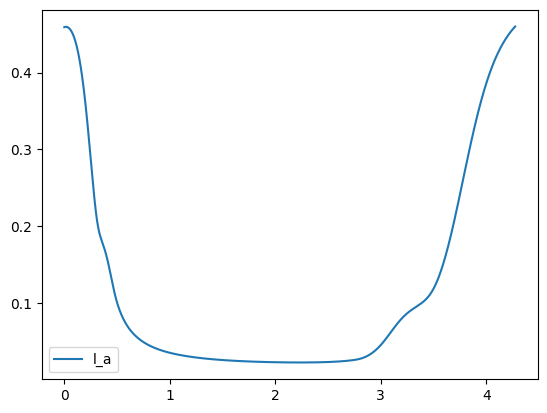

In [8]:
m = 23
l_a_single_peak, t_single_peak = make_longer_bound(l_a_interp[0,:], t_interp, t_interp[1]-t_interp[0])
fourier_coeff = fourier_coefficients(l_a_single_peak,m)

l_a_fourier = fourier_series(fourier_coefficients(l_a_single_peak,m)[0],fourier_coefficients(l_a_single_peak,m)[1],len(l_a_single_peak))
plt.plot(t_interp,l_a_interp[0,:],label="l_a")
plt.legend()

In [9]:
rel_err = .3         
kwargs_sys = { 
    'nu_min': nu0 - nu0 *rel_err,'nu_max': nu0 + nu0 *rel_err,
    'm_min': m0 - m0 *rel_err,'m_max' : m0 + m0 *rel_err,
    'l_g_min': l_g0 - l_g0 *rel_err,'l_g_max': l_g0 + l_g0 *rel_err,
    'l_p_min': l_p0 - l_p0 *rel_err,'l_p_max': l_p0 + l_p0 *rel_err,
    'k_g_min': k_g0 - k_g0 *rel_err,'k_g_max': k_g0 + k_g0 *rel_err,
    'k_p_min': k_p0 - k_p0 *rel_err,'k_p_max': k_p0 + k_p0 *rel_err,
    'k_a_min': k_a0 - k_a0 *rel_err,'k_a_max': k_a0 + k_a0 *rel_err,
    'eta_min': .5,'eta_max': .5,
    't_interp': t_interp,
    't_single_peak': t_single_peak,
    'N_interp': N_interp,
    'x_cm':x_cm_interp,
    'x_j':x_j_interp,
    'l_a':l_a_interp,
    'l_a_single_peak':l_a_single_peak,
    'la0_0':l_a0,
    'x1_0':x_i[0,0],
    'x2_0':x_i[0,1],
    'y1_0':(x_i[1,0]-x_i[0,0])/delta_t,
    'y2_0':(x_i[1,1]-x_i[0,1])/delta_t,
    'N_sys': 1    
}

#upper and lower bounds for parameters

tol = 0
real_params_low = {'l_p':l_p0- l_p0*tol,'l_g':l_g0- l_g0*tol,
                   'k_g':k_g0- k_g0*tol,'k_p':k_p0- k_p0*tol,
                   'k_a':k_a0- k_a0*tol,'m':m0- m0*tol,'nu':nu0- nu0*tol,'eta':.5,'dt':-.25}
real_params_up = {'l_p':l_p0+ l_p0*tol,'l_g':l_g0+ l_g0*tol,
                  'k_g':k_g0+ k_g0*tol,'k_p':k_p0+ k_p0*tol,
                  'k_a':k_a0+ k_a0*tol,'m':m0+ m0*tol,'nu':nu0+ nu0*tol,'eta':.5,'dt':.25}

In [10]:
nan_array = jnp.full((1, len(t_evals)), 1.)
targets = {"x1":x_i[:,0].reshape((1,len(t_evals))),'x2':x_i[:,1].reshape((1,len(t_evals))),'y1':nan_array,'y2':nan_array}
#kwargs for adoptODE
kwargs_adoptODE = {'lr':3e-2, 'epochs':1000,'N_backups':1,
                   'lower_b_y0':{'x1':y0['x1'],'x2':y0['x2'],'y1':y0['y1']-0.01*y0['y1'],'y2':y0['y2']-0.01*y0['y2'] },
                   'upper_b_y0':{'x1':y0['x1'],'x2':y0['x2'],'y1':y0['y1']+0.01*y0['y1'],'y2':y0['y2']+0.01*y0['y2'] },
                   'lower_b': real_params_low,
                   'upper_b': real_params_up}
#define the dataset
dataset = dataset_adoptODE(sm_model,
                                targets,
                                t_evals, 
                                kwargs_sys,
                                kwargs_adoptODE, 
                                true_params = real_params
                                )

In [11]:
params_final, losses, errors, params_history = train_adoptODE(dataset,save_interval=100)
print(params_final)

Epoch 000:  Loss: 3.2e-04,  Params Err.: 3.6e+00, y0 error: nan, Params Norm: 2.5e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 100:  Loss: 4.4e-06,  Params Err.: 6.8e-02, y0 error: nan, Params Norm: 2.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 200:  Loss: 4.4e-06,  Params Err.: 6.8e-02, y0 error: nan, Params Norm: 2.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 300:  Loss: 4.4e-06,  Params Err.: 6.8e-02, y0 error: nan, Params Norm: 2.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 400:  Loss: 4.4e-06,  Params Err.: 6.8e-02, y0 error: nan, Params Norm: 2.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 500:  Loss: 4.4e-06,  Params Err.: 6.8e-02, y0 error: nan, Params Norm: 2.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 600:  Loss: 4.4e-06,  Params Err.: 6.8e-02, y0 error: nan, Params Norm: 2.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 700:  Loss: 4.4e-06,  Params Err.: 6.8e-02, y0 error: na

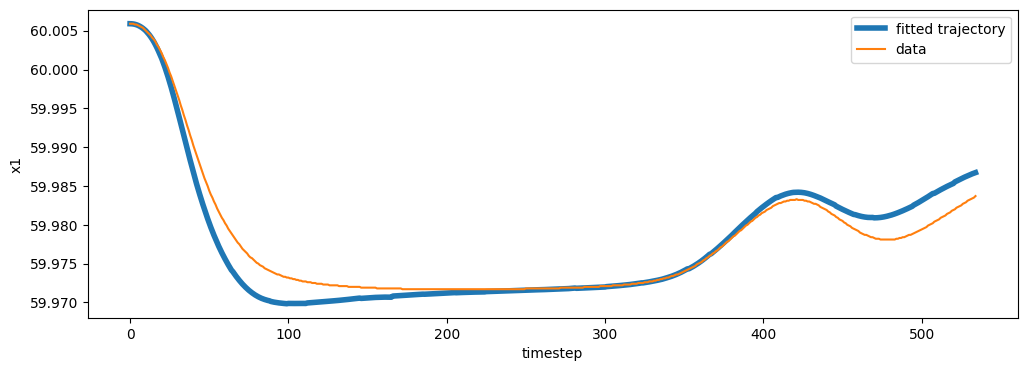

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(dataset.ys_sol['x1'][0,0:],linewidth = 4,label= 'fitted trajectory')
plt.plot(x_i[0:,0],label = 'data')
plt.ylabel('x1')
plt.xlabel('timestep')
plt.legend()

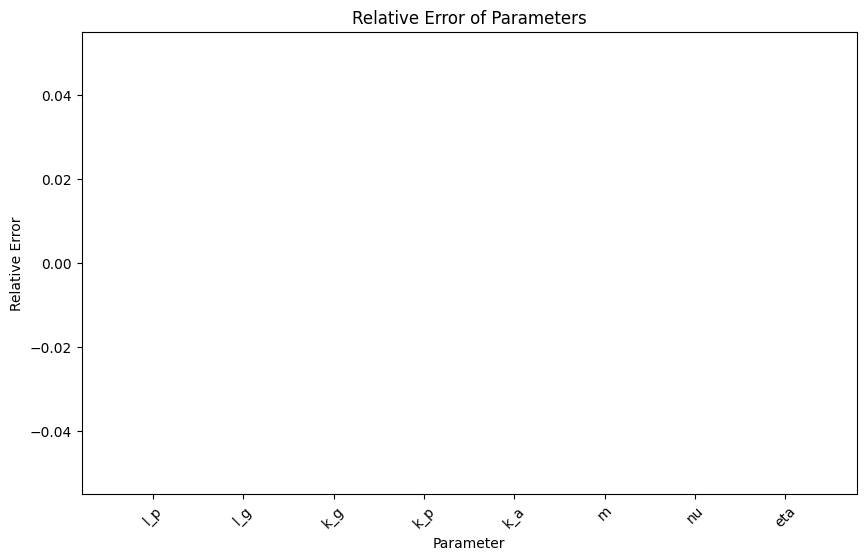

In [13]:
# Get the parameter names
param_names = list(real_params.keys())

# Calculate the relative error for each parameter
relative_errors = []
for param_name in param_names:
    real_value = real_params.get(param_name, np.nan)
    train_value = dataset.params_train.get(param_name, np.nan)
    if np.isnan(real_value) or np.isnan(train_value):
        relative_errors.append(np.nan)
    else:
        relative_error = np.abs((train_value - real_value) / real_value)
        relative_errors.append(relative_error)

# Plot the relative errors
plt.figure(figsize=(10, 6))
plt.bar(param_names, relative_errors)
plt.xlabel('Parameter')
plt.ylabel('Relative Error')
plt.title('Relative Error of Parameters')
plt.xticks(rotation=45)
plt.show()

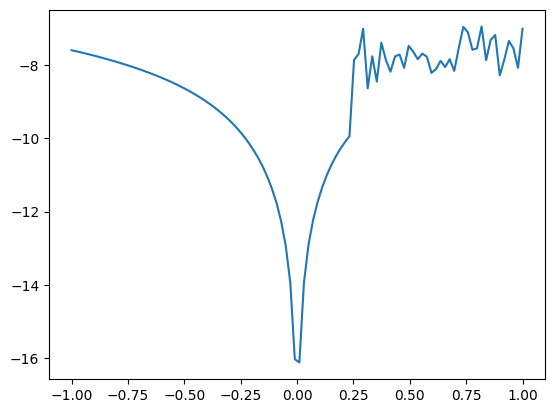

In [14]:
dt_error = np.load('../data/SpringMassModel/dtError/dt_error1.npy')
dt = np.linspace(-1,1,100)

plt.plot(dt, np.log(dt_error))